*시작 전, 상단 메뉴 '파일' > '드라이브에 사본 저장' 을 선택하여 사본을 가지고 작업을 진행해주시기 바랍니다.*  

# 공지
- Dataset: https://drive.google.com/file/d/1Ow7u1i--_qHkmcBW8mo4xW3MBodwhxVm/view?usp=sharing
- csv 파일 제출: dcc2021.clustering@gmail.com (발표 자료는 다른 곳으로 제출하셔야 합니다!!!)
- 리더 보드: https://github.com/High-East/DCC-6-Leader-Board
- 총 제출 횟수는 ***20번*** 입니다.
- 이메일 보낸 시간을 기준으로, 대회 종료 시각인 ***PM 4:20*** 까지 제출하신 것까지만 인정합니다.
- 평가 지표는 ARI를 사용하고 있습니다. [-1, 1] 사이의 값을 가지며, 1에 가까울수록 높은 성능입니다.


# 문제
> Q. 2030년, 드디어 인공지능이 탑재된 로봇이 실생활에서 적용되기 시작했습니다. 과일 가게에서 일하는 로봇 "Apple"이 있습니다. "Apple"은 트럭에서 과일을 가게로 운반하는 일을 하는 하고 있습니다. "Apple"이 같은 종류의 과일을 같은 곳에 쌓을 수 있기 위해서는, 군집을 도와주는 알고리즘이 필요합니다. 로봇이 사고를 치지 않도록 군집 알고리즘을 만들어보세요!

# 데이터 설명
훈련 데이터(Train Data): 4,035개의 레이블이 없는 과일 이미지 데이터  
평가 데이터(Test Data): 훈련 데이터와 동일  
피쳐 설명(Feature): (100, 100) 크기의 컬러 사진  
목표: 가장 적합한 군집의 개수를 찾고, 높은 군집 정확도 얻기  

# 구글 드라이브 마운트

In [ ]:
# 구글 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# 폴더 이동
import os
ROOT = '/content/gdrive/MyDrive'  # 변경하지 마세요. 단, MyDrive가 오류난다면, My\ Drive로 적으세요.
DIR = '데이터캠프'  # 데이터와 ipynb파일이 있는 위치를 적으세요.

PATH = os.path.join(ROOT, DIR)
os.chdir(PATH)

In [ ]:
# 할당 받은 GPU 확인
!nvidia-smi

# 패키지 임포트

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, activations
from tensorflow.keras import optimizers
from sklearn.cluster import KMeans

import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from ipywidgets import interact

print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {tf.keras.__version__}")

tensorflow version: 2.6.0
keras version: 2.6.0


# 커스텀 함수 정의

In [ ]:
# Visualization function
def show_img(dataset, predict, idx):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(cv2.cvtColor(dataset[idx], cv2.COLOR_BGR2RGB))
    ax1.set_title("Raw image")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(cv2.cvtColor(predict[idx], cv2.COLOR_BGR2RGB))
    ax2.set_title("Reconstructed image")
    plt.show()


# Elbow method
def elbow_method(X, a, b):
    sse = []
    for i in range(a, b + 1):
        km = KMeans(n_clusters=i, init='k-means++', random_state=1207)
        km.fit(X)
        sse.append(km.inertia_)
    plt.figure(figsize=(8,6))
    plt.plot(range(a, b + 1), sse, marker='o', c='black')
    plt.xlabel("Number of clusters", fontsize=12)
    plt.ylabel("SSE", fontsize=12)
    plt.title("Elbow method", fontsize=15)
    plt.grid(linestyle='--')
    plt.show()

# 데이터 로드

In [ ]:
# 데이터 로드
path = "dataset.npy"
dataset = np.load(path)
dataset = np.float32(dataset / 255)  # 데이터 정규화

# 데이터 shape 확인
print(f"dataset shape: {dataset.shape}")

dataset shape: (4035, 100, 100, 3)


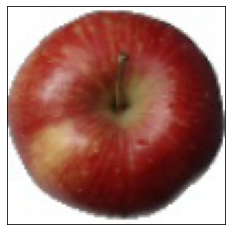

In [ ]:
# 이미지 확인
idx = 10
plt.imshow(cv2.cvtColor(dataset[idx], cv2.COLOR_BGR2RGB))
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

# 차원 축소
- PCA와 같은 다른 차원 축소 기법을 사용해도 괜찮습니다.

## 오토인코더

In [ ]:
# 인코더
encoder = models.Sequential([
          layers.InputLayer(input_shape=(100, 100, 3)),
          layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Flatten(),
          layers.Dense(units=128, activation='relu')
          ],
          name='Encoder')

# 모델 구조 시각화
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0   

In [ ]:
# 디코더
decoder = models.Sequential([
          layers.InputLayer(input_shape=(128)),  # 인코더의 마지막 output shape을 입력하세요.
          layers.Dense(units=5000, activation='relu'),
          layers.Reshape(target_shape=(25, 25, 8)),
          layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same"),
          layers.BatchNormalization(),
          layers.ReLU(),
          layers.Conv2D(filters=3, kernel_size=1, strides=1, activation='tanh'),
         ],
          name='Decoder')

# 모델 구조 시각화
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5000)              645000    
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 50, 50, 64)        4672      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 100, 100, 32)      18464     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 100, 32)      128 

In [ ]:
# 오토인코더: 인코더 + 디코더 구조
autoencoder = models.Sequential([
              layers.InputLayer(input_shape=(100, 100, 3), name='Input'),
              encoder,  # 인코더
              decoder])  # 디코더

## 학습
- Optimizer, loss 및 모든 하이퍼파라미터를 자유롭게 조정하며 실험해보세요.
- Optimizer 참고 자료 1 : https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- Optimizer 참고 자료 2: https://keras.io/ko/optimizers/
- Loss 참고자료 1: https://www.tensorflow.org/api_docs/python/tf/keras/losses
- Loss 참고자료 2: https://keras.io/ko/losses/

In [ ]:
# 하이퍼파라미터 설정
optimizer = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
epochs = 50
batch_size = 16

# 모델 컴파일(=optimizer, loss 세팅)
autoencoder.compile(optimizer=optimizer,
                    loss=loss)

# 학습
autoencoder.fit(x=dataset, y=dataset, epochs=epochs, batch_size=batch_size)

## 복원된 이미지 확인

In [ ]:
# 오토인코더를 통해 얻은 이미지(=복원된 이미지)
max_len = 10  # 최대 10개의 이미지 보기
predict = autoencoder(dataset[:max_len])

# 시각화
slider = widgets.IntSlider(min=0, max=max_len, step=1, value=0)
interact(lambda idx: show_img(dataset[:max_len], predict.numpy(), idx), idx=slider)

In [ ]:
y

# 클러스터링(K-means)
- 클러스터링 기법 변경하셔도 상관 없습니다.

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=30).fit(dataset)
dataset = pca.transform(dataset)

## Latent vector 얻기

In [ ]:
# Extract latent vector(mini-batch version, OOM 방지)
batch_size = 64
latent_vec = []
num_batch = len(dataset) // batch_size

for i in range(num_batch + 1):
    batch_set = dataset[i * batch_size:(i + 1) * batch_size]
    latent_vec.append(encoder(batch_set).numpy())

latent_vec = np.concatenate(latent_vec, axis=0)

if np.ndim(latent_vec) != 2:
    latent_vec = np.reshape(latent_vec, [len(dataset), -1])

## Cluster 개수 결정

In [ ]:
# Elbow method를 통해서 최적의 cluster 개수(K)를 찾아보세요.
# K는 15이하입니다.
# latent_vec의 크기가 클수록 런타임이 오래 걸리니 참고하세요.
start = 1
end = 15
elbow_method(latent_vec, start, end)

In [ ]:
# K-Means clustering
n_clusters = 8  # elbow method 등을 이용해서 K를 결정해보세요.
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=1207).fit(latent_vec)
y_pred = kmeans.labels_

In [ ]:
y_pred

# 제출 파일

In [ ]:
# 저장할 폴더 만들기
SAVE_PATH = os.path.join(PATH, "output")
if not os.path.exists(SAVE_PATH):
  os.mkdir(SAVE_PATH)
else:
  pass

In [ ]:
# 제출 파일 만들기
team = "비타맥스5"  # 반드시 팀명을 적어주세요.

# 이 밑은 수정하지 마세요.
timestamp = datetime.today().strftime("%Y%m%d%H%M%S")  # ex) timestamp 20210911131000
sub = pd.DataFrame(y_pred, columns=["y_pred"])
sub.to_csv(os.path.join(SAVE_PATH, f"./{team}_{timestamp}.csv"), index=False)